In [224]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from cv2 import SIFT_create, cvtColor, COLOR_RGB2GRAY, FlannBasedMatcher, drawMatchesKnn
rgb2gray = lambda img: cvtColor(img, COLOR_RGB2GRAY)
sift = SIFT_create(contrastThreshold=0.02, edgeThreshold=10, nOctaveLayers=3)

%matplotlib widget  

In [225]:
#from project_helpers import *
from project_helpers import get_dataset_info, enforce_essential, compute_epipolar_errors, estimate_F_DLT, count_points_in_front, extract_P_from_E, plot_camera, triangulate_3D_point_DLT

In [226]:
# Extracting data

def read_images(img_names):
  images = []
  for name in img_names:
    images.append((plt.imread(name) * 255).astype('uint8'))
  return images

In [227]:
# Getting SIFT points and descriptors

def extract_sift_features(images):

  keypoints = []
  descriptors = []
  for image in images:
    kp, des = sift.detectAndCompute(rgb2gray(image), None)
    keypoints.append(kp)
    descriptors.append(des)
  return keypoints, descriptors

In [228]:
def find_good_matches(des1, des2):
  all_matches = FlannBasedMatcher().knnMatch(des1, des2, k=2)
  print('all matches', len(all_matches))
  
  good_matches = []
  for m,n in all_matches:
      if m.distance < 0.75*n.distance:
          good_matches.append([m])
  print('god matches', len(good_matches), '\n ')
  
  return good_matches

Matching sift points and descriptors

In [229]:
def get_2d_points(kp1, kp2, des1, des2, good_matches):
  
  points_1 = []
  points_2 = []
  
  des1_match = []
  des2_match = []
  
  for match in good_matches:
    idx_1 = match[0].queryIdx
    idx_2 = match[0].trainIdx
    
    points_1.append([kp1[idx_1].pt[0], kp1[idx_1].pt[1]])
    des1_match.append(des1[idx_1])
    
    points_2.append([kp2[idx_2].pt[0], kp2[idx_2].pt[1]])
    des2_match.append(des2[idx_2])
  
  x1 = np.array(points_1)
  x2 = np.array(points_2)
  
  x1_homo = np.vstack((x1.T, np.ones(x1.shape[0])))
  x2_homo = np.vstack((x2.T, np.ones(x2.shape[0])))
  
  #print('x1_homo', x1_homo.shape)
  #print('des1_match', len(des1_match))
  
  keypoint_pair = [x1_homo,x2_homo]
  descriptor_pair = [des1_match, des2_match]
    
  return keypoint_pair, descriptor_pair

In [230]:
def get_matching_2D_3D(x, X, good_matches):
  
  x_matched_list = []
  X_matched_list = []
  
  for match in good_matches:
    idx_2D = match[0].queryIdx
    idx_3D = match[0].trainIdx
    
    x_matched_list.append(x[:, idx_2D])
    
    X_matched_list.append(X[:, idx_3D])
  
  x_matched = np.array(x_matched_list).T
  X_matched = np.array(X_matched_list).T
  
  #print('x1_homo', x1_homo.shape)
  #print('des1_match', len(des1_match))
    
  return x_matched, X_matched

Estimating E robustly and extracting P fro E

In [231]:
def estimate_E_and_inliers(x1, x2, des1, des2, eps, seed=None):
    """
    RANSAC estimate of essential matrix using normalized correspondences x1 and x2 and a normalized threshold.
    Note: Make sure to normalize things before using it in this function!
    -------------------------------------------
    x1: Normalized keypoints in image 1 - 3xN np.array or 2xN np.array, as you desire 
    x2: Normalized keypoints in image 2 - 3xN np.array or 2xN np.array, as you desire 
    eps: Normalized inlier threshold - float

    Returns:
    E: 3x3 essential matrix
    inliers: The inlier points
    errs: The epipolar errors
    iters: How many iterations it took
    """
    
    num_points = x1.shape[1]
    num_inliers = 0
    best_num_inliers = 0
    best_inlier_mask = None
    best_errs = None
    iters = 0
    max_iters = 200
    
    
    while iters < max_iters:
        iters += 1
        randind = np.random.choice(num_points, size=8, replace=False)
        E = enforce_essential(estimate_F_DLT(x1[:, randind], x2[:, randind]))
        e1 = compute_epipolar_errors(E, x1, x2)**2 
        e2 = compute_epipolar_errors(E.T, x2, x1)**2
        
        errs = (1/2)*(e1+e2)
        inlier_mask = errs < eps**2
        num_inliers = sum(inlier_mask)

        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_errs = errs
            best_inlier_mask = inlier_mask
            ratio_inliers = num_inliers/num_points
            if ratio_inliers > 0.8:
                break
    
    x1_inliers = x1[:, best_inlier_mask]
    x2_inliers = x2[:, best_inlier_mask]
    
    inlier_points = [x1_inliers, x2_inliers]
    
    #print('x1 shape', x1.shape)
    #print('des1 shape', np.array(des1).shape)
    
    des1_inliers = np.array(des1)[best_inlier_mask]
    des2_inliers = np.array(des2)[best_inlier_mask]
            
    E = enforce_essential(estimate_F_DLT(x1_inliers, x2_inliers))
    
    errs = best_errs
    #print('inliers',sum(best_inlier_mask))
    
    return E, inlier_points, des1_inliers, des2_inliers, errs, iters

In [232]:
def get_P(E_robust, keypoint_pair):

  P1_k = np.array([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0]])
  
  x1, x2 = keypoint_pair
  
  P2_extract = extract_P_from_E(E_robust)
  
  best_i = None
  best_count = 0

  for i in range(4):
    count = count_points_in_front(P1_k, P2_extract[i], x1, x2)
    print('Cam', i, 'inliers', count)
    if count > best_count:
        best_count = count
        best_i = i
        
  print(' ')
  best_P2 = P2_extract[best_i]
  camera_matrix = best_P2
    
  return camera_matrix

In [233]:
def estimate_camera_DLT(x, Xmodel):
    if x.shape[0] != 3:
        raise ValueError("x must be of shape 3xN")
    
    if Xmodel.shape[0] != 4:
        raise ValueError("Xmodel must be of shape 4xN")
    
    x_h = x.copy()
    Xmodel_h = Xmodel.copy()
    
    n = x_h.shape[1]
    
    M = np.zeros((2*n, 12), dtype=float)
    
    for i in range(n):
        u = x_h[0, i]
        v = x_h[1, i]
        X = Xmodel_h[:, i]
        
        M[2*i, 0:4] = X
        M[2*i, 8:12] = -u*X
        
        M[2*i+1, 4:8] = X
        M[2*i+1, 8:12] = -v*X
        
    U, S, Vt = np.linalg.svd(M)
    
    v = Vt[-1]
    
    P = v.reshape((3, 4))
    
    P /= P[-1, -1]
    
    
    print(np.linalg.norm(M @ v))
    print(S[-1])
    
    return P


In [234]:
def triangulate_3D_points_DLT_loop(x1_k, x2_k, P1, P2):
  n = x1_k.shape[1]
  X = np.zeros((4,n))
  for i in range(n):
    point_3D = triangulate_3D_point_DLT(x1_k[:, i], x2_k[:, i], P1, P2)
    X[:,i] = point_3D
  
  return X

In [235]:
def estimate_T_DLT(x, X, R):
    n = x.shape[1]
    A = np.zeros((2*n, 3))
    b = np.zeros(2*n)

    for i in range(n):
        Xw = X[:3, i]

        R1 = R[0]
        R2 = R[1]
        R3 = R[2]

        u = x[0, i]
        v = x[1, i]

        A[2*i]   = [1, 0, -u]
        A[2*i+1] = [0, 1, -v]

        b[2*i]   = u * (R3 @ Xw) - (R1 @ Xw)
        b[2*i+1] = v * (R3 @ Xw) - (R2 @ Xw)

    t = np.linalg.lstsq(A, b, rcond=None)[0]
    return t.reshape(3,1)

In [236]:
def compute_reprojection_error(P, X, x):
    
    X_proj = P @ X
    X_proj /= X_proj[2]
    diff = X_proj[:2] - x[:2]
    errs = np.sum(diff**2, axis=0)

    return errs

In [237]:
def estimate_T_robust(x, X, R_abs, eps, seed=None):

    num_points = x.shape[1]
    print('num points', num_points)
    
    num_inliers = 0
    best_num_inliers = 0
    best_inlier_mask2 = None
    best_errs = None
    iters = 0
    max_iters = 200
    
    while iters < max_iters:
        iters += 1
        randind = np.random.choice(num_points, size=8, replace=False)
        T = estimate_T_DLT(x[:, randind], X[:, randind], R_abs)
        
        P = np.hstack((R_abs, T))
        errs = compute_reprojection_error(P, X, x) 
        inlier_mask = errs < eps
        num_inliers = sum(inlier_mask)

        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_errs = errs
            best_inlier_mask2 = inlier_mask
            ratio_inliers = num_inliers/num_points
            if ratio_inliers > 0.8:
                break
    
    print('x[:, best_inlier_mask2]', x[:, best_inlier_mask2].shape)
    
    #best_inlier_mask = best_inlier_mask.reshape(-1)
    
    best_T = estimate_T_DLT(x[:, best_inlier_mask2], X[:, best_inlier_mask2], R_abs)
    
    
    #print('inliers',sum(best_inlier_mask))
    
    return best_T

In [238]:
def filter_3d_outliers(Xh, quantile=0.9, scale=5.0):
    """
    Xh: 4xN homogeneous 3D points
    """

    # Convert to Euclidean coordinates
    X = Xh[:3, :] / Xh[3, :]

    # Center of gravity
    X_mean = np.mean(X, axis=1, keepdims=True)

    # Distances to centroid
    dists = np.linalg.norm(X - X_mean, axis=0)

    # Threshold
    thresh = scale * np.quantile(dists, quantile)

    # Inliers
    mask = dists <= thresh

    return Xh[:, mask]

In [239]:
def run_sfm(dataset_num):

  # Step 1 calculate relative orientations

  seed = 1

  # Get dataset info
  K, img_names, init_pair, pixel_threshold = get_dataset_info(dataset_num)
  #init_pair = [4,6]
  print('init', init_pair)

  eps = 10*pixel_threshold / K[0,0]

  # Read images
  images = read_images(img_names)

  # Extract keypoints and descriptors
  keypoints, descriptors = extract_sift_features(images)

  # Setting initial matrix
  P_0 = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0]])

  camera_matrices = [P_0]
  R_rel = []

  keypoints_pair_inlier = []
  descriptors_pair_inlier = []

  N = len(images)

  for i in range(N-1):
    print('Image pair', i)
    
    kp1 = keypoints[i]
    kp2 = keypoints[i+1]
    des1 = descriptors[i]
    des2 = descriptors[i+1]
    
    # Finding good matches
    good_matches = find_good_matches(des1, des2)
    
    # Using sift features and good matches to get keypoints and corresponding descriptors
    keypoints_pair, descriptors_pair_match = get_2d_points(kp1, kp2, des1, des2, good_matches)
    
    x1, x2 = keypoints_pair
    
    xn1 = np.linalg.inv(K) @ x1
    xn2 = np.linalg.inv(K) @ x2
    
    des1_match, des2_match = descriptors_pair_match
    
    E_robust, inliers, des1_inliers, des2_inliers, _, _ = estimate_E_and_inliers(xn1, xn2, des1_match, des2_match, eps, seed = 1)
    
    # Calculating camera matrix and corresponding inliers
    P_i = get_P(E_robust, inliers)
    
    # Saving camera matrix, keypoints and their descriptors
    camera_matrices.append(P_i)
    
    R = P_i[:, :3]
    R_rel.append(R)
    
    keypoints_pair_inlier.append(inliers)
    descriptors_pair_inlier.append([des1_inliers, des2_inliers])
    
    # Step 2 - Upgrade to relative rotations

  R_abs = []
  R_abs.append(np.eye(3))

  for i in range(1, len(images)):
      R_abs.append(R_rel[i-1] @ R_abs[i-1])

  R_abs = np.array(R_abs)

  # Step 3 - Reconstructing image points from initial image pair

  kp1_init = keypoints[init_pair[0]]
  kp2_init = keypoints[init_pair[1]]
  des1_init = descriptors[init_pair[0]]
  des2_init = descriptors[init_pair[1]]

  matches_init_pair = find_good_matches(des1_init, des2_init)
  points_init_pair, descriptors_init_pair = get_2d_points(kp1_init, kp2_init, des1_init, des2_init, matches_init_pair)

  x1, x2 = points_init_pair

  xn1 = np.linalg.inv(K) @ x1
  xn2 = np.linalg.inv(K) @ x2

  des1_match, des2_match = descriptors_init_pair

  E_robust, inliers, des1_inliers, des2_inliers, _, _ = estimate_E_and_inliers(xn1, xn2, des1_match, des2_match, eps, seed = 1)

  P_init_pair = get_P(E_robust, inliers)

  X_init = triangulate_3D_points_DLT_loop(inliers[0], inliers[1], P_0, P_init_pair)
  X_init_filtered = filter_3d_outliers(X_init)

  des_abs = des1_inliers

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(X_init_filtered[0, :], X_init_filtered[1, :], X_init_filtered[2, :], s=2, c='b', label='Original')

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.legend()
  ax.view_init(90, 35)
  ax.set_aspect('equal')

  plot_camera(P_0,1,ax)
  plot_camera(P_init_pair,1,ax)

  plt.show()

  # Step 4 - Robustly calculating camera center/translation for each image

  P_abs = [P_0]

  for i in range(N - 1):
    kp_i = keypoints_pair_inlier[i][1]
    des_i = descriptors_pair_inlier[i][1]
    
    good_matches = find_good_matches(des_i, des_abs)
    
    x_i_matched, X_init_matched = get_matching_2D_3D(kp_i, X_init, good_matches)
    
    print('xi', x_i_matched.shape)
    print('Xi', X_init_matched.shape)
    
    R = R_abs[i+1]
    eps = 0.00007
    
    T = estimate_T_robust(x_i_matched, X_init_matched, R, eps)
    P = np.hstack((R, T))
    P_abs.append(P)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(X_init_filtered[0, :], X_init_filtered[1, :], X_init_filtered[2, :], s=1, c='b', label='Original')

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.legend()
  ax.view_init(90, 35)
  ax.set_aspect('equal')


  print(len(P_abs))
  for P in P_abs:
    plot_camera(P,1,ax)

  plt.show()

  # Step 6 - Triangulating points for all pairs

  for i in range(N - 1):
    P1 = P_abs[i]
    P2 = P_abs[i+1]
    
    print('Cam pair', i, i+1)
    
    x1 = keypoints_pair_inlier[i][0]
    x2 = keypoints_pair_inlier[i][1]
    
    good_matches = find_good_matches(des_i, des_abs)
    
    x_i_matched, X_init_matched = get_matching_2D_3D(kp_i, X_init, good_matches)
    
    X = triangulate_3D_points_DLT_loop(x1, x2, P1, P2)
    X_filtered = filter_3d_outliers(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X_filtered[0, :], X_filtered[1, :], X_filtered[2, :], s=1, c='b', label='Original')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.view_init(90, 35)
    ax.set_aspect('equal')

    plot_camera(P1,1,ax)
    plot_camera(P2,1,ax)

    plt.show()

init [4, 7]
Image pair 0
all matches 40147
god matches 18378 
 
Cam 0 inliers 0
Cam 1 inliers 0
Cam 2 inliers 0
Cam 3 inliers 18125
 
Image pair 1
all matches 41222
god matches 17177 
 
Cam 0 inliers 0
Cam 1 inliers 0
Cam 2 inliers 16928
Cam 3 inliers 9
 
Image pair 2
all matches 40309
god matches 18632 
 
Cam 0 inliers 18401
Cam 1 inliers 1
Cam 2 inliers 0
Cam 3 inliers 0
 
Image pair 3
all matches 43230
god matches 18507 
 
Cam 0 inliers 0
Cam 1 inliers 0
Cam 2 inliers 2
Cam 3 inliers 18166
 
Image pair 4
all matches 41728
god matches 18256 
 
Cam 0 inliers 17989
Cam 1 inliers 3
Cam 2 inliers 0
Cam 3 inliers 0
 
Image pair 5
all matches 40800
god matches 18406 
 
Cam 0 inliers 0
Cam 1 inliers 0
Cam 2 inliers 15563
Cam 3 inliers 0
 
Image pair 6
all matches 40070
god matches 17449 
 
Cam 0 inliers 2
Cam 1 inliers 16860
Cam 2 inliers 0
Cam 3 inliers 0
 
Image pair 7
all matches 40155
god matches 18164 
 
Cam 0 inliers 0
Cam 1 inliers 0
Cam 2 inliers 17205
Cam 3 inliers 0
 
Image pair 8

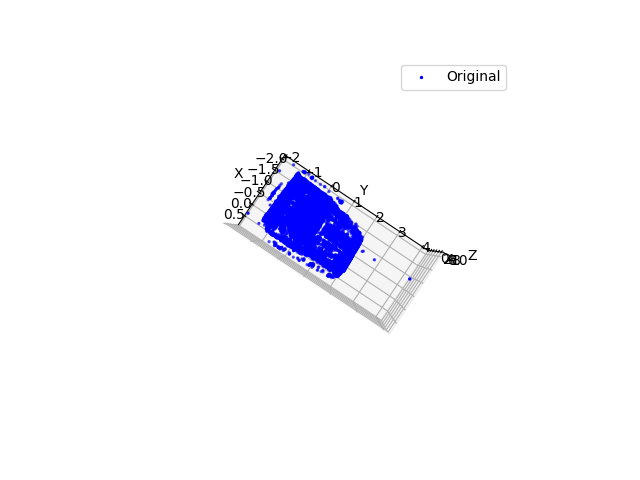

all matches 18125
god matches 4625 
 
xi (3, 4625)
Xi (4, 4625)
num points 4625
x[:, best_inlier_mask2] (3, 819)
all matches 16937
god matches 4903 
 
xi (3, 4903)
Xi (4, 4903)
num points 4903
x[:, best_inlier_mask2] (3, 946)
all matches 18402
god matches 5573 
 
xi (3, 5573)
Xi (4, 5573)
num points 5573
x[:, best_inlier_mask2] (3, 1100)
all matches 18168
god matches 7905 
 
xi (3, 7905)
Xi (4, 7905)
num points 7905
x[:, best_inlier_mask2] (3, 1606)
all matches 17992
god matches 8212 
 
xi (3, 8212)
Xi (4, 8212)
num points 8212
x[:, best_inlier_mask2] (3, 1623)
all matches 15563
god matches 5851 
 
xi (3, 5851)
Xi (4, 5851)
num points 5851
x[:, best_inlier_mask2] (3, 1217)
all matches 16862
god matches 7830 
 
xi (3, 7830)
Xi (4, 7830)
num points 7830
x[:, best_inlier_mask2] (3, 1430)
all matches 17205
god matches 6986 
 
xi (3, 6986)
Xi (4, 6986)
num points 6986
x[:, best_inlier_mask2] (3, 1274)
all matches 18968
god matches 5395 
 
xi (3, 5395)
Xi (4, 5395)
num points 5395
x[:, best_

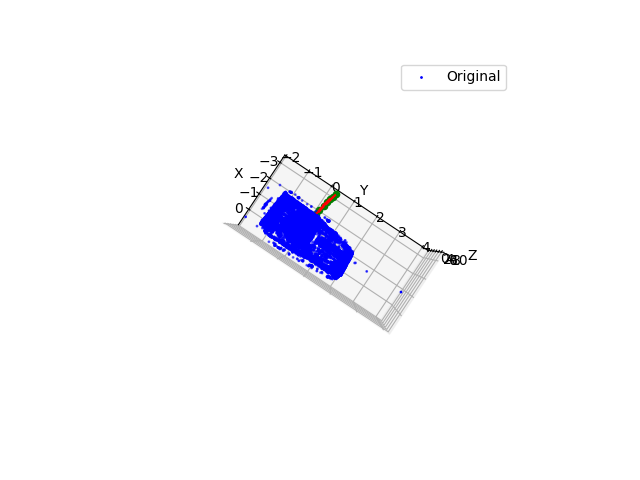

Cam pair 0 1
all matches 19304
god matches 4344 
 


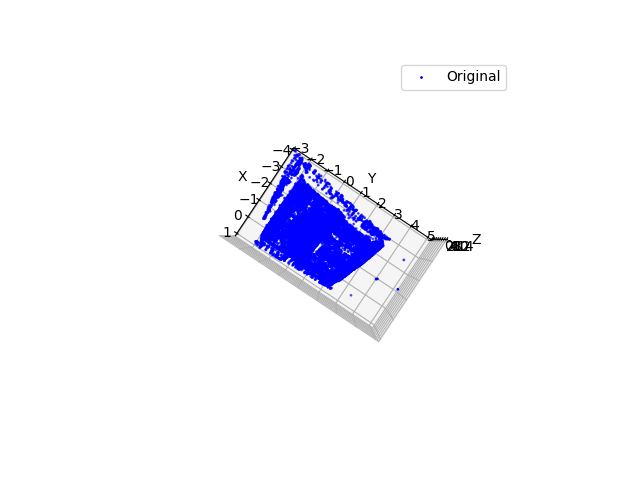

Cam pair 1 2
all matches 19304
god matches 4347 
 


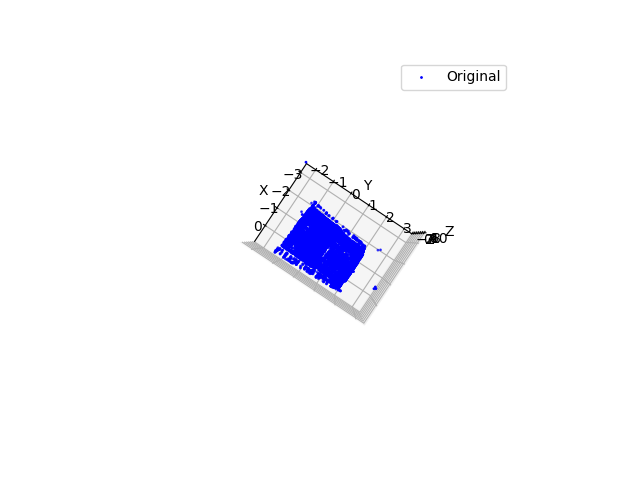

Cam pair 2 3
all matches 19304
god matches 4314 
 


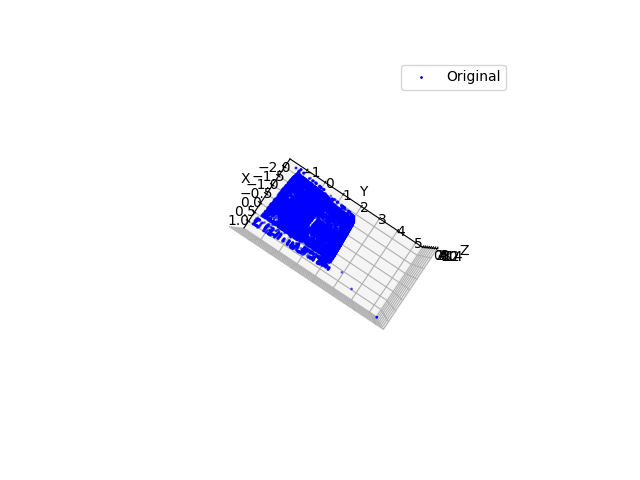

Cam pair 3 4
all matches 19304
god matches 4339 
 


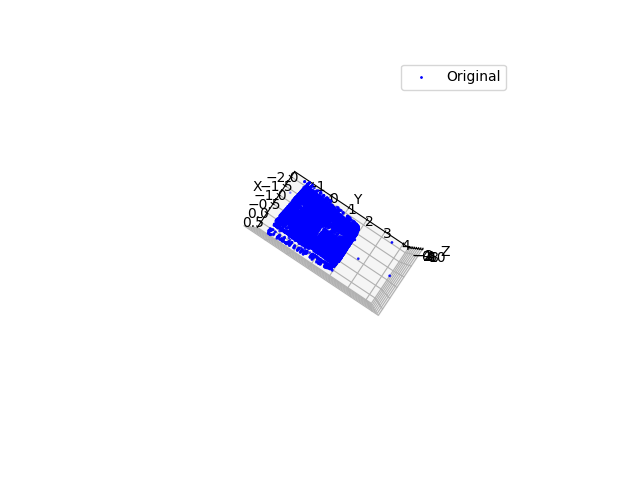

Cam pair 4 5
all matches 19304
god matches 4342 
 


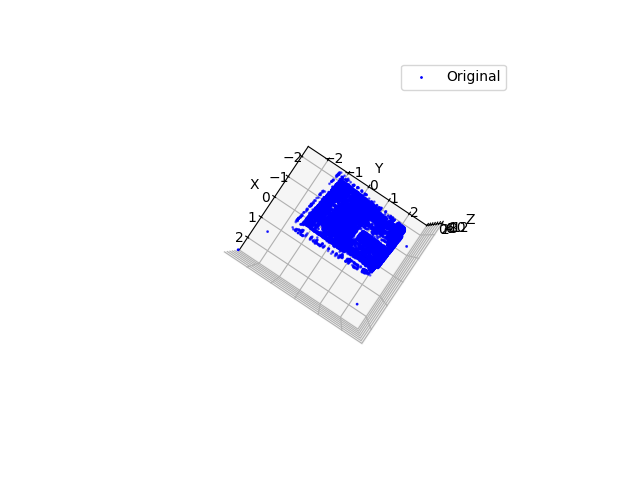

Cam pair 5 6
all matches 19304
god matches 4331 
 


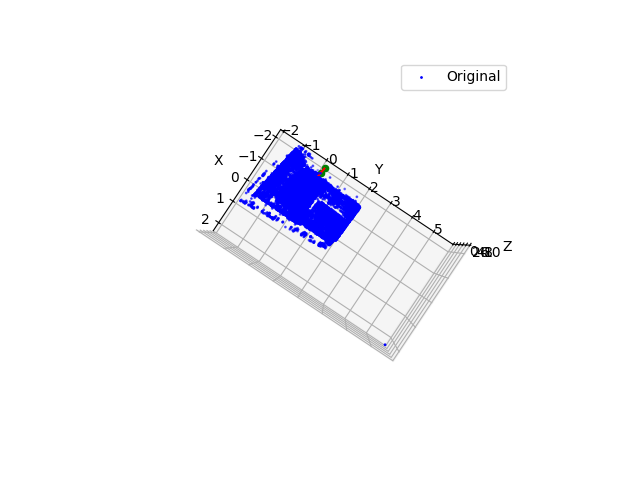

Cam pair 6 7
all matches 19304
god matches 4329 
 


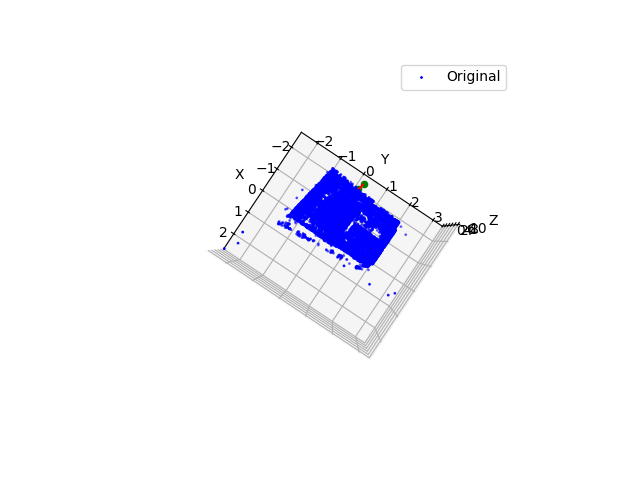

Cam pair 7 8
all matches 19304
god matches 4371 
 


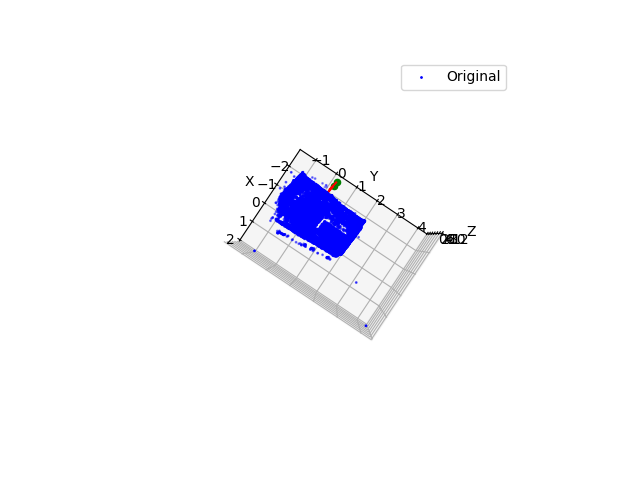

Cam pair 8 9
all matches 19304
god matches 4347 
 


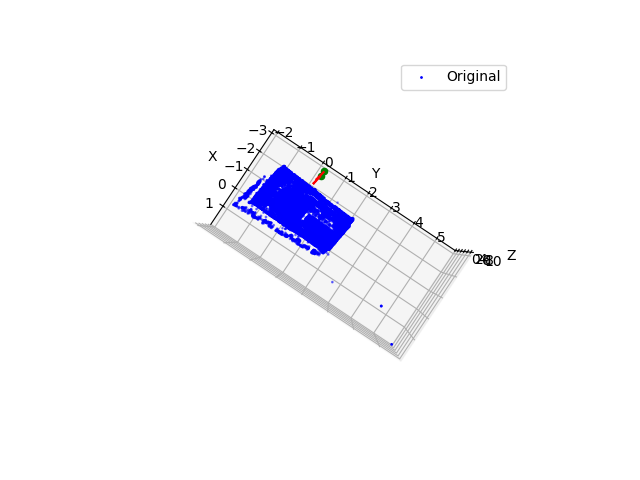

Cam pair 9 10
all matches 19304
god matches 4361 
 


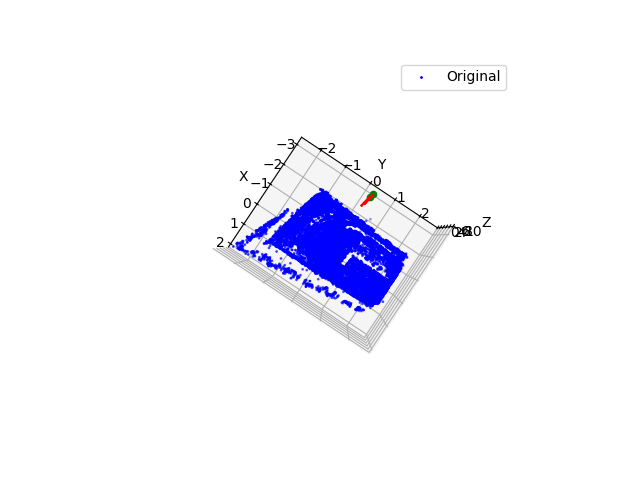

Cam pair 10 11
all matches 19304
god matches 4373 
 


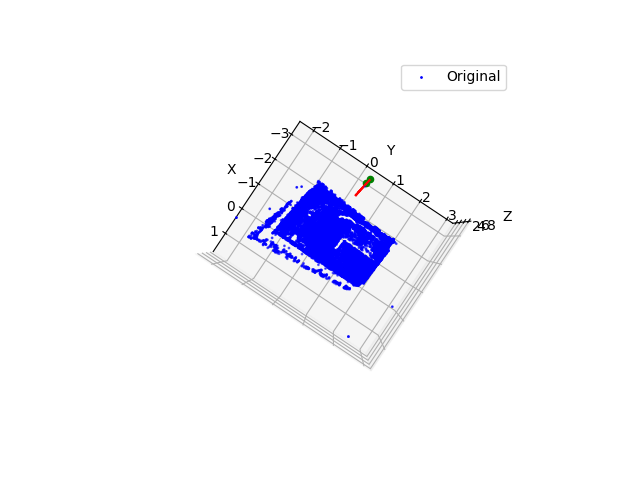

In [240]:
run_sfm(3)